In [42]:
from warnings import simplefilter
from tqdm import TqdmWarning

simplefilter("ignore", UserWarning)
simplefilter("ignore", TqdmWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlforecast import MLForecast

from statsmodels.stats.diagnostic import acorr_ljungbox

from utilsforecast.feature_engineering import trend, fourier

from fpppy.models import LinearRegression
from fpppy.utils import plot_series

from utils import *

plt.style.use("ggplot")
import matplotlib as mpl
from cycler import cycler

mpl.rcParams["axes.prop_cycle"] = cycler(color=mpl.cm.tab10(range(10)))
simplefilter("ignore", category=pd.errors.PerformanceWarning)
pd.set_option("display.precision", 3)

# Table of contents
1. [The linear model](#the-linear-model)
2. [Least squares estimation](#least-squares-estimation)
3. [Evaluating the regression model](#evaluating-the-regression-model)
4. [Some useful predictors](#some-useful-predictors)
5. [Selecting predictors](#selecting-predictors)
6. [Forecasting with regression](#forecasting-with-regression)

# [The linear model](https://otexts.com/fpppy/nbs/07-regression.html#sec-regression-intro)

In [2]:
us_change = pd.read_csv("data/US_change.csv", parse_dates=["ds"])
us_change.head()

,ds,y,Income,Production,Savings,Unemployment,unique_id
0,1970-01-01,0.619,1.045,-2.452,5.299,0.9,US_change
1,1970-04-01,0.452,1.226,-0.551,7.790,0.5,US_change
2,1970-07-01,0.873,1.585,-0.359,7.404,0.5,US_change
3,1970-10-01,-0.272,-0.240,-2.186,1.170,0.7,US_change
4,1971-01-01,1.901,1.976,1.910,3.536,-0.1,US_change


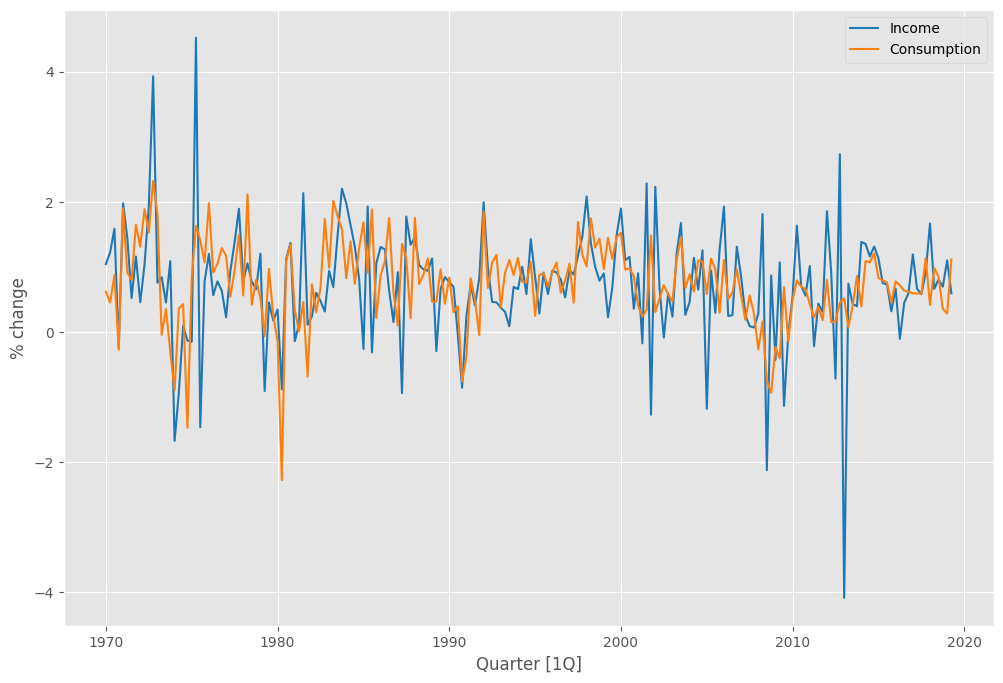

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(us_change["ds"], us_change["Income"], label="Income")
ax.plot(us_change["ds"], us_change["y"], label="Consumption")
ax.set_xlabel("Quarter [1Q]")
ax.set_ylabel("% change")
ax.legend()
plt.show()

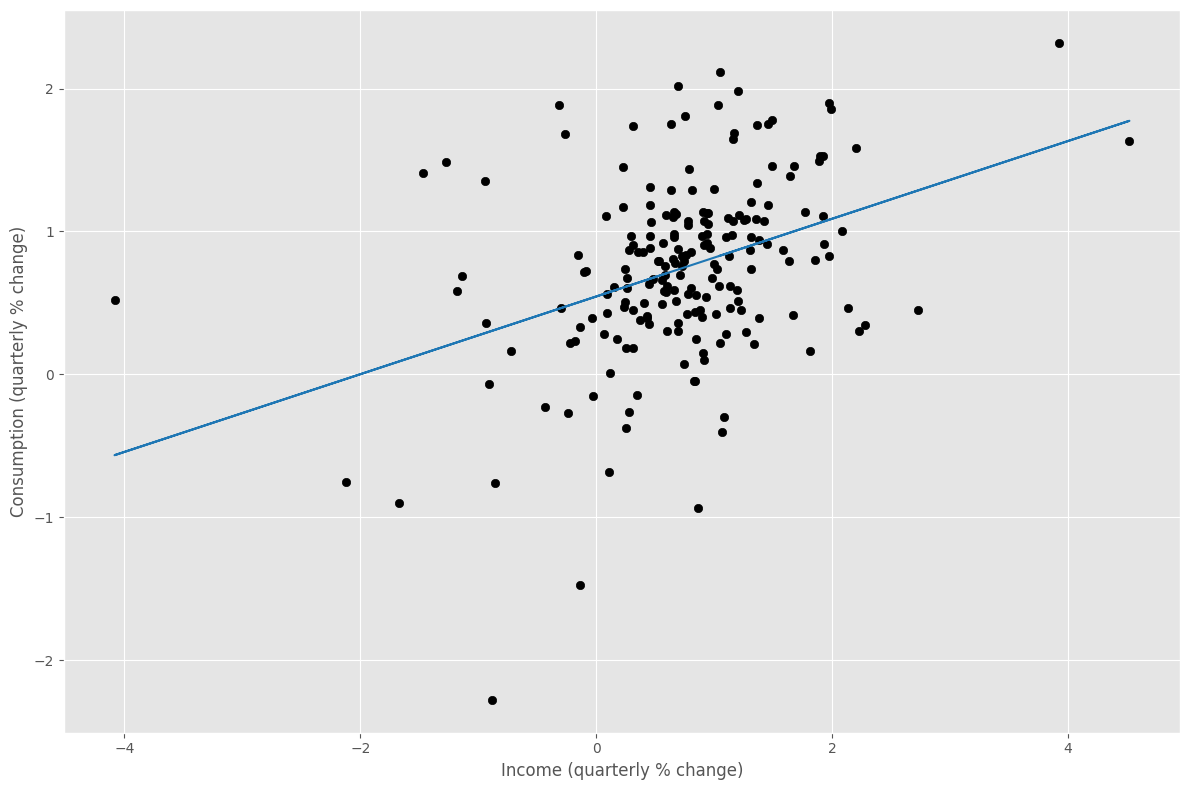

In [4]:
mf = MLForecast(models=LinearRegression(), freq="QS-OCT")
mf.fit(us_change[["ds", "Income", "y", "unique_id"]], fitted=True, static_features=[])
# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(us_change["Income"], us_change["y"], c="k")
ax.plot(us_change["Income"], mf.forecast_fitted_values()["LinearRegression"])

# Customize the plot
ax.set_xlabel("Income (quarterly % change)")
ax.set_ylabel("Consumption (quarterly % change)")
plt.tight_layout()
plt.show()

In [5]:
print_regression_summary_from_model(mf.models_["LinearRegression"])

#> Residuals:
#>     Min      1Q  Median      3Q     Max 
#> -2.5824 -0.2778  0.0186  0.3233  1.4223

#> Coefficients:
#>                Estimate  Std. Error   t value  Pr(>|t|)
#>   (Intercept)    0.5445      0.0540     10.08         0 ***
#>        Income    0.2718      0.0467      5.82   2.4e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.591 on 196 degrees of freedom
Multiple R-squared: 0.147,   Adjusted R-squared: 0.143
F-statistic: 33.8 on 196 DF, p-value: 2.4e-08


## Multiple linear regression

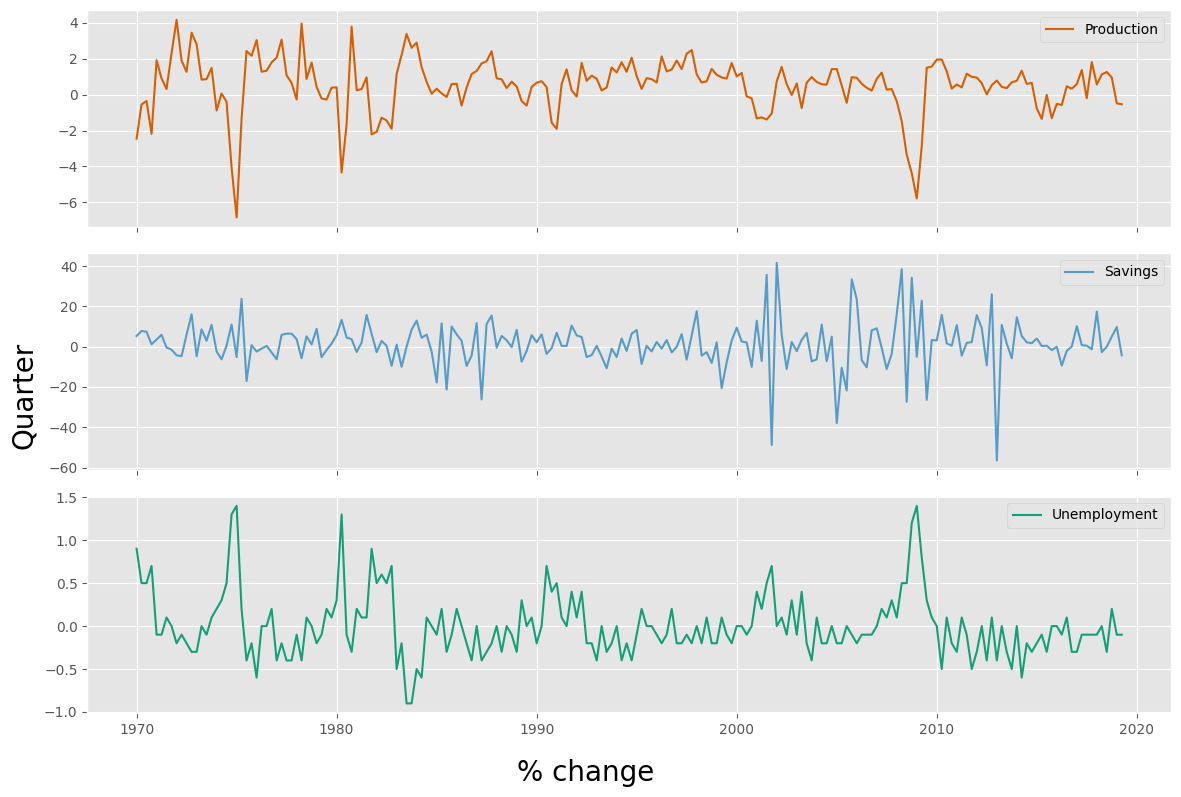

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True)
sns.lineplot(
    data=us_change,
    x="ds",
    y="Production",
    ax=axes[0],
    color="#D55F03",
    label="Production",
)
sns.lineplot(
    data=us_change, x="ds", y="Savings", ax=axes[1], color="#569CC6", label="Savings"
)
sns.lineplot(
    data=us_change,
    x="ds",
    y="Unemployment",
    ax=axes[2],
    color="#13A076",
    label="Unemployment",
)
for ax in axes:
    ax.set_ylabel("")
    ax.set_xlabel("")
fig.supxlabel("% change", fontsize=20)
fig.supylabel("Quarter", fontsize=20)
plt.tight_layout()
plt.show()

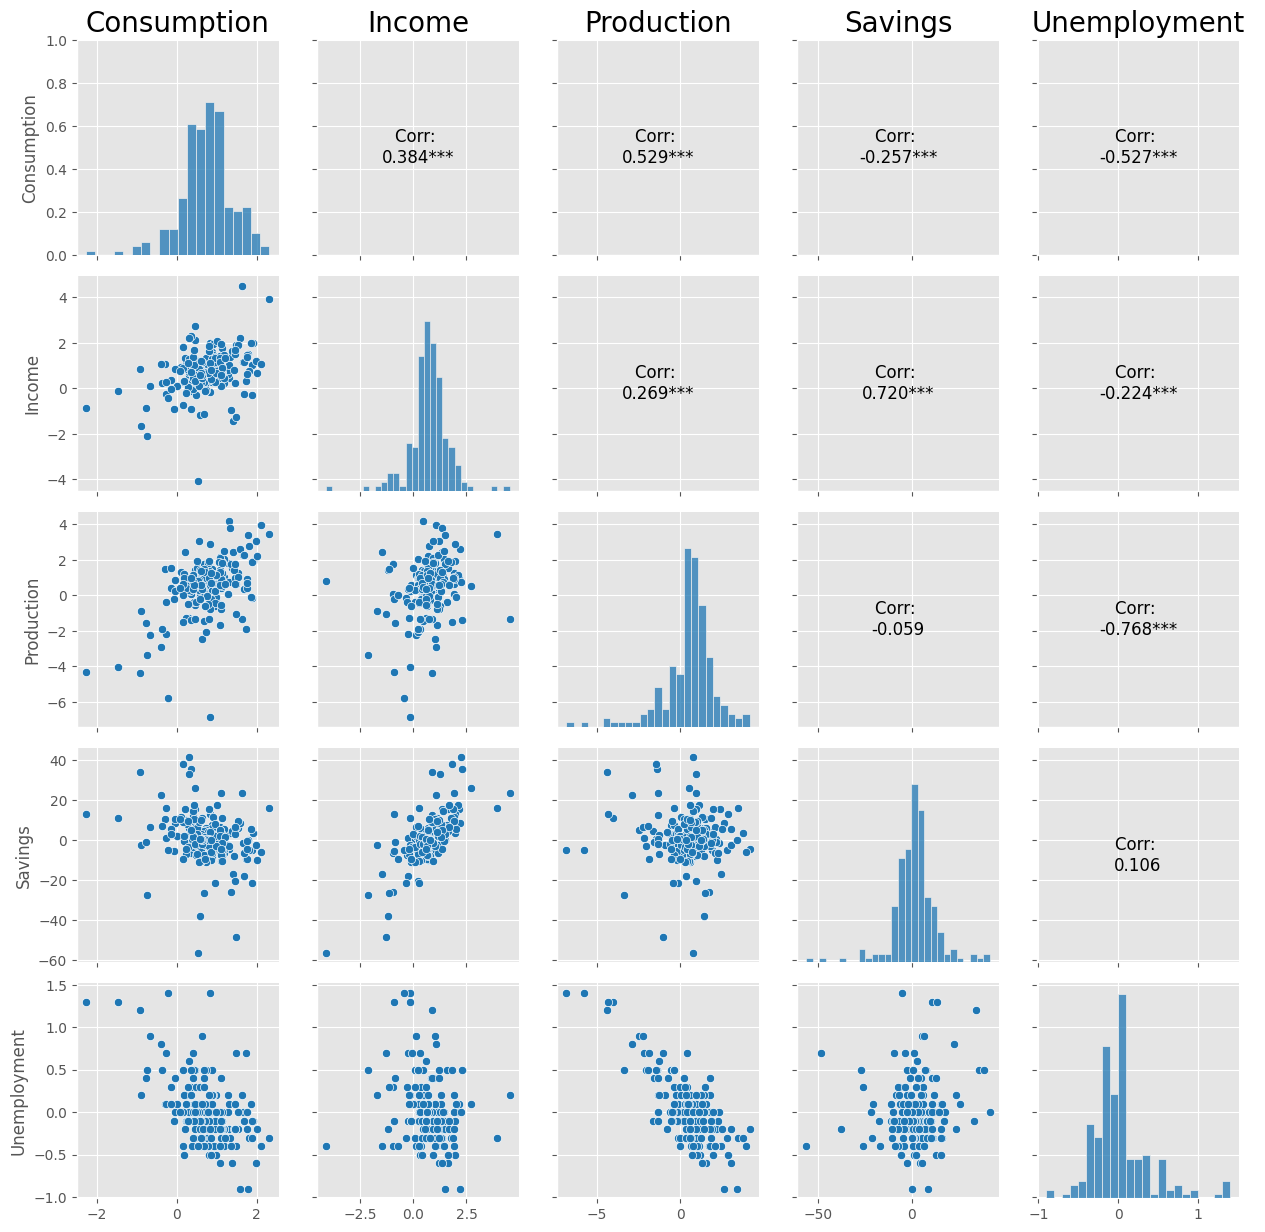

In [7]:
plot_df = us_change[["y", "Income", "Production", "Savings", "Unemployment"]].copy()
plot_df = plot_df.rename(columns={"y": "Consumption"})

g = sns.PairGrid(plot_df)
g.map_diag(sns.histplot)
g.map_upper(corrfunc)
g.map_lower(sns.scatterplot)
g.add_legend()
# Remove default axis labels
g.set(xlabel="")

# Move y-axis labels to the top
for i, col in enumerate(plot_df.columns):
    g.axes[0, i].set_title(col, fontsize=20)
plt.show()

# [Least squares estimation](https://otexts.com/fpppy/nbs/07-regression.html#sec-least-squares)

In [8]:
mf = MLForecast(models=LinearRegression(), freq="QS-OCT")

# Fit model
mf.fit(us_change, fitted=True, static_features=[])

print_regression_summary_from_model(mf.models_["LinearRegression"])

#> Residuals:
#>     Min      1Q  Median      3Q     Max 
#> -0.9055 -0.1582 -0.0361  0.1362  1.1547

#> Coefficients:
#>                Estimate  Std. Error   t value  Pr(>|t|)
#>   (Intercept)    0.2531      0.0345      7.34  5.71e-12 ***
#>        Income    0.7406      0.0401     18.46         0 ***
#>    Production    0.0472      0.0231      2.04    0.0429 *
#>       Savings   -0.0529      0.0029    -18.09         0 ***
#>  Unemployment   -0.1747      0.0955     -1.83    0.0689 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.310 on 193 degrees of freedom
Multiple R-squared: 0.768,   Adjusted R-squared: 0.763
F-statistic: 160.0 on 193 DF, p-value: 1.11e-16


In [9]:
mf.forecast_fitted_values()

,unique_id,ds,y,LinearRegression
0,US_change,1970-01-01,0.619,0.474
1,US_change,1970-04-01,0.452,0.635
2,US_change,1970-07-01,0.873,0.931
3,US_change,1970-10-01,-0.272,-0.212
4,US_change,1971-01-01,1.901,1.637
...,...,...,...,...
193,US_change,2018-04-01,0.983,0.940
194,US_change,2018-07-01,0.853,0.966
195,US_change,2018-10-01,0.357,0.512
196,US_change,2019-01-01,0.283,0.547


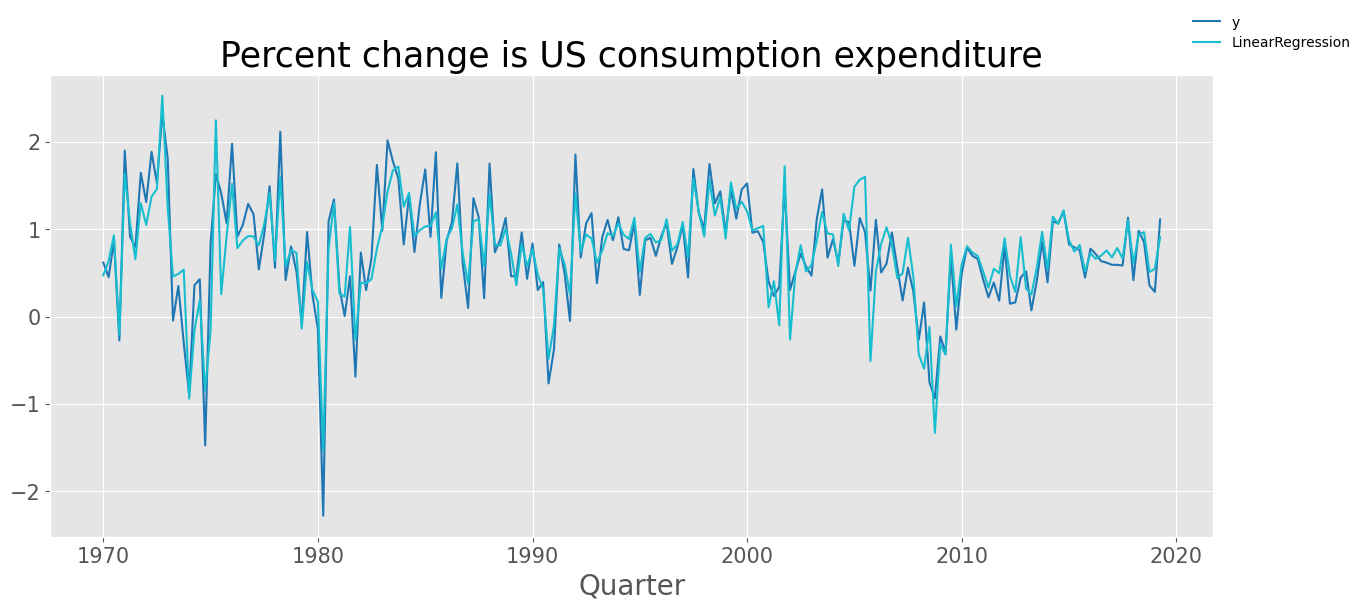

In [ ]:
plot_series(
    us_change,
    mf.forecast_fitted_values().drop(columns="y"),
    xlabel="Quarter",
    ylabel="",
    title="Percent change is US consumption expenditure",
    rm_legend=False,
)

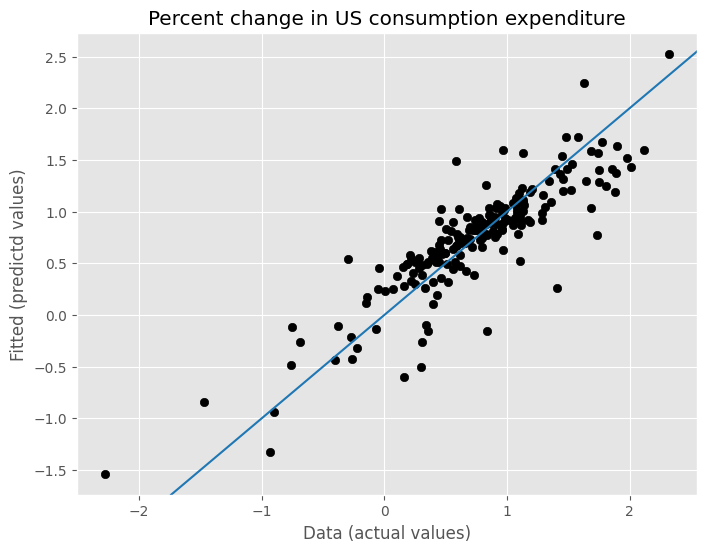

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
insample_forecasts = mf.forecast_fitted_values()["LinearRegression"]
ax.scatter(us_change["y"], insample_forecasts, c="k")
ax.axline((0, 0), (1, 1))
ax.set_xlabel("Data (actual values)")
ax.set_ylabel("Fitted (predictd values)")
ax.set_title("Percent change in US consumption expenditure")
plt.show()

# [Evaluating the regression model](https://otexts.com/fpppy/nbs/07-regression.html#sec-regression-evaluation)

In [ ]:
model = mf.models_["LinearRegression"]
print(f"Sum of residuals: {np.sum(model._residuals)}")
for column in model._X.columns:
    print(
        f"Correlation between residuals and {column}: {np.dot(model._X[column].values, model._residuals)}"
    )

Sum of residuals: 1.7763568394002505e-15
Correlation between residuals and Income: 3.84969833788773e-14
Correlation between residuals and Production: -1.472433286409114e-14
Correlation between residuals and Savings: -1.0869083411080283e-13
Correlation between residuals and Unemployment: -2.1510571102112408e-16


## ACF plot and histogram of residuals

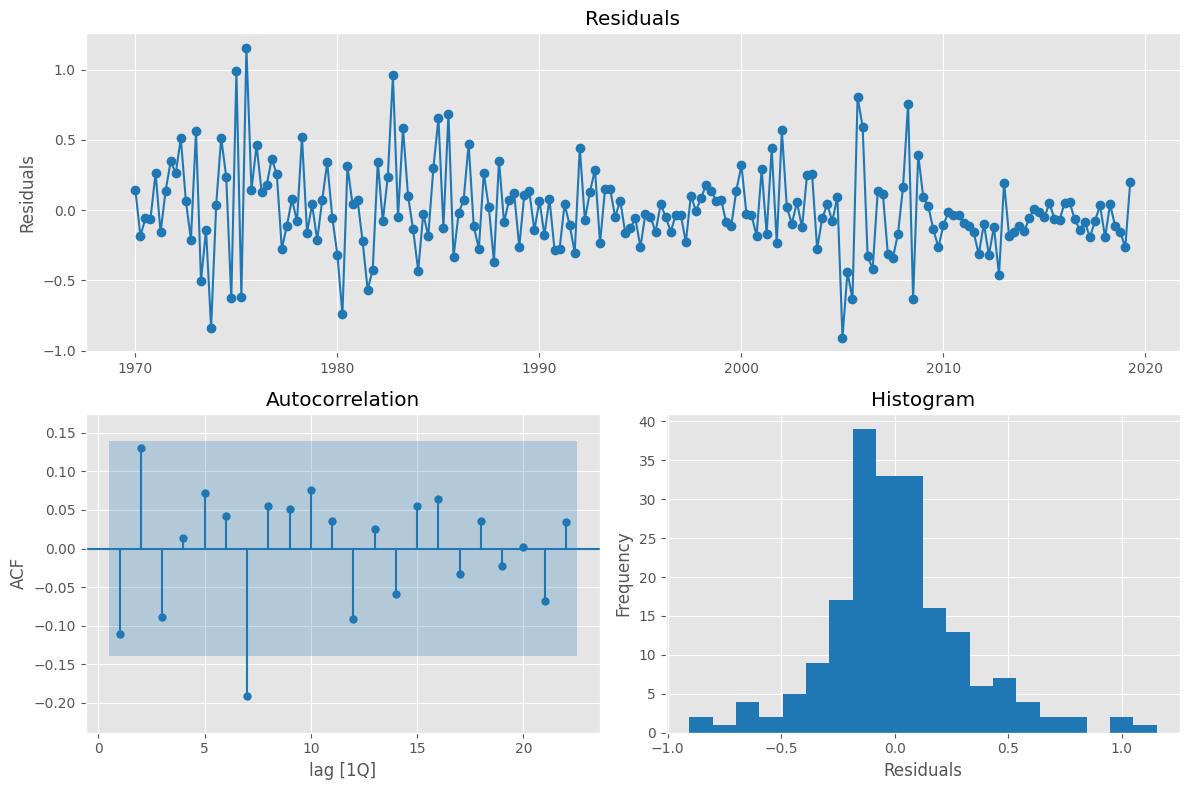

In [13]:
plot_diagnostics_from_model(forecaster=mf, n_lags=22)

In [14]:
residuals = mf.models_["LinearRegression"]._residuals
acorr_ljungbox(residuals, lags=[10])

,lb_stat,lb_pvalue
10,18.865,0.042


## Residual plots against predictors

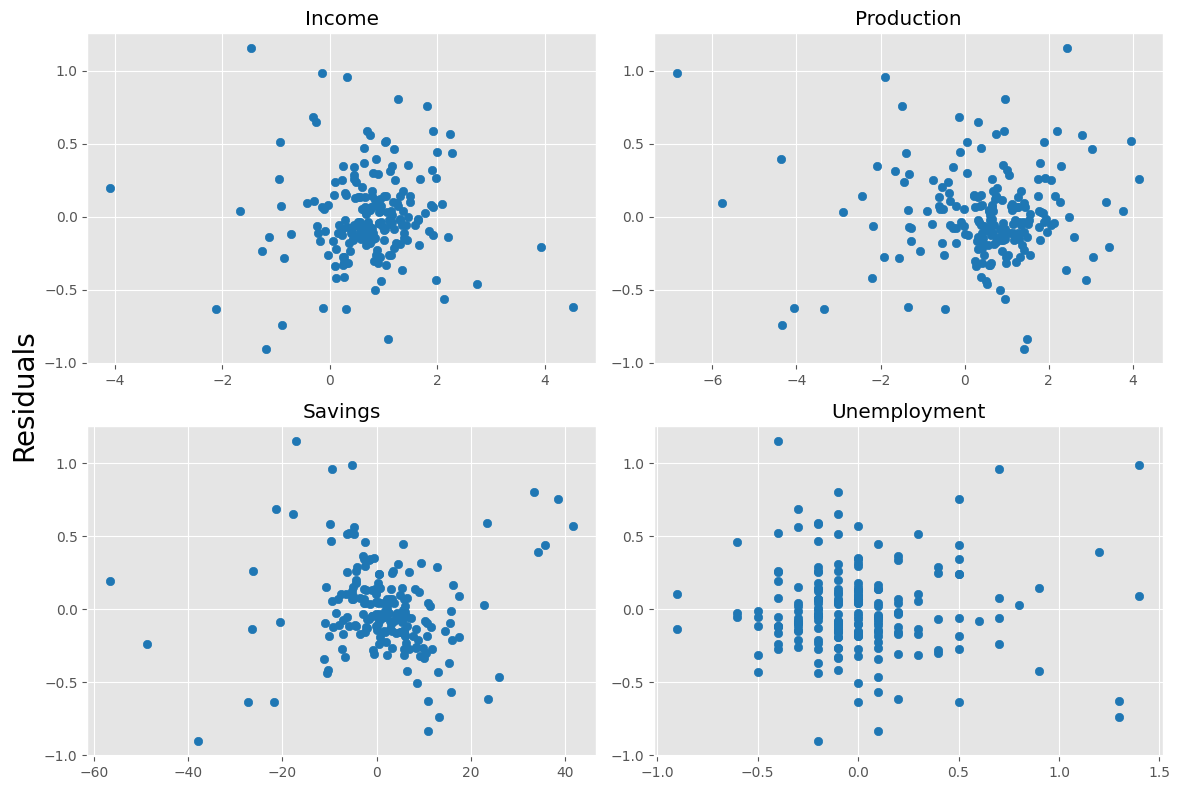

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax[0, 0].scatter(us_change["Income"], residuals)
ax[0, 0].set_title("Income")

ax[0, 1].scatter(us_change["Production"], residuals)
ax[0, 1].set_title("Production")

ax[1, 0].scatter(us_change["Savings"], residuals)
ax[1, 0].set_title("Savings")

ax[1, 1].scatter(us_change["Unemployment"], residuals)
ax[1, 1].set_title("Unemployment")

fig.supylabel("Residuals", fontsize=20)
plt.tight_layout()
plt.show()

## Residual plots against fitted values

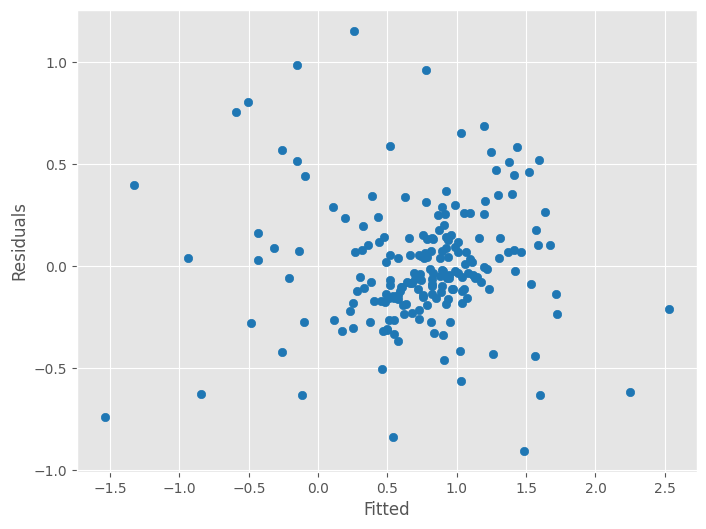

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(insample_forecasts, residuals)
ax.set_xlabel("Fitted")
ax.set_ylabel("Residuals")
plt.show()

## Spurious regression

In [17]:
aus_airpassengers = pd.read_csv("data/aus_airpassengers.csv", index_col=0)
aus_airpassengers.head()

,Year,Passengers
1,1970,7.319
2,1971,7.327
3,1972,7.796
4,1973,9.385
5,1974,10.665


In [18]:
rice_production_guinea = pd.read_csv("data/guinea_rice_unparsed.csv", index_col=0)
rice_production_guinea.head()

,Year,Production
1,1970,0.311
2,1971,0.325
3,1972,0.340
4,1973,0.355
5,1974,0.370


In [19]:
tmp_df = pd.merge(aus_airpassengers, rice_production_guinea, on="Year")
tmp_df.head()

,Year,Passengers,Production
0,1970,7.319,0.311
1,1971,7.327,0.325
2,1972,7.796,0.340
3,1973,9.385,0.355
4,1974,10.665,0.370


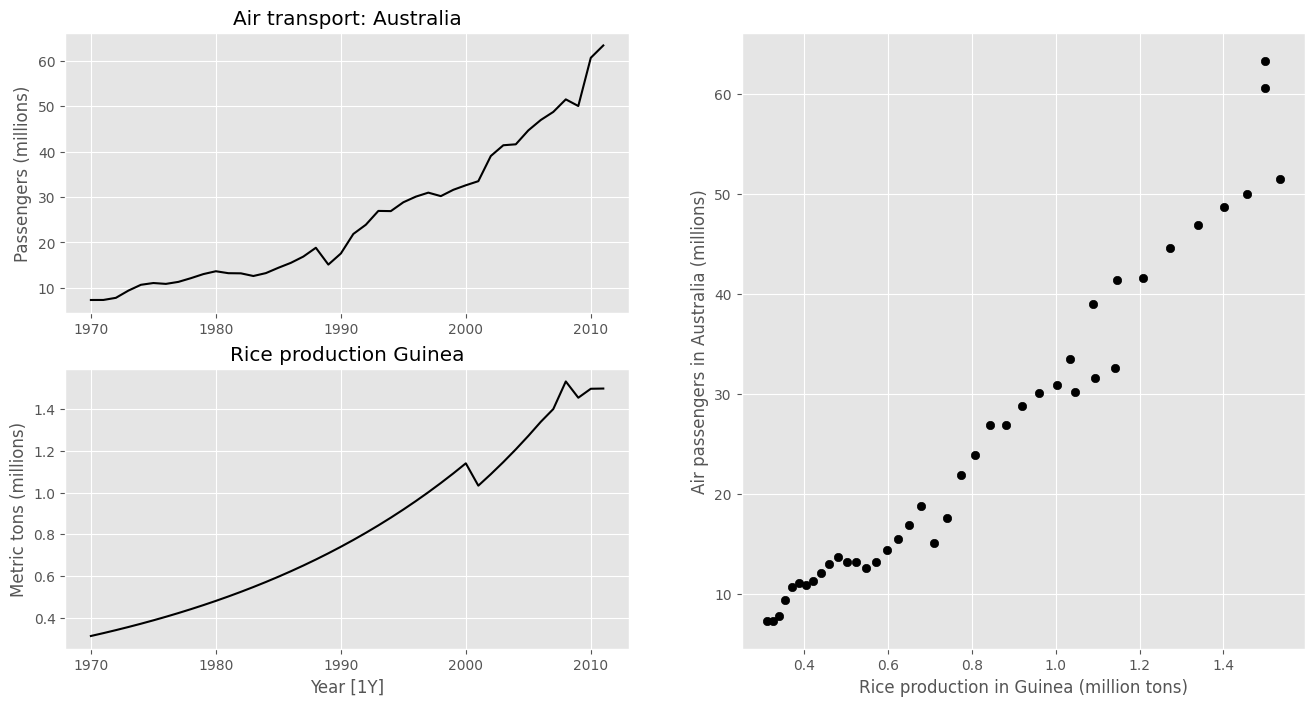

In [ ]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(tmp_df["Year"], tmp_df["Passengers"], c="k")
ax1.set_title("Air transport: Australia")
ax1.set_ylabel("Passengers (millions)")

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(tmp_df["Year"], tmp_df["Production"], c="k")
ax2.set_title("Rice production Guinea")
ax2.set_xlabel("Year [1Y]")
ax2.set_ylabel("Metric tons (millions)")

ax3 = fig.add_subplot(2, 2, (2, 4))
ax3.scatter(tmp_df["Production"], tmp_df["Passengers"], c="k")
ax3.set_xlabel("Rice production in Guinea (million tons)")
ax3.set_ylabel("Air passengers in Australia (millions)")
plt.show()

In [ ]:
mf = MLForecast(models=LinearRegression(), freq=1)

tmp_df["unique_id"] = "AirPassengers"
mf.fit(
    tmp_df,
    fitted=True,
    time_col="Year",
    target_col="Passengers",
    static_features=[],
)

insample_forecasts = mf.forecast_fitted_values()["LinearRegression"]
residuals = (
    mf.forecast_fitted_values()["Passengers"]
    - mf.forecast_fitted_values()["LinearRegression"]
)
print_regression_summary_from_model(mf.models_["LinearRegression"])

#> Residuals:
#>     Min      1Q  Median      3Q     Max 
#> -5.9448 -1.8917 -0.3272  1.8620 10.4210

#> Coefficients:
#>                Estimate  Std. Error   t value  Pr(>|t|)
#>   (Intercept)   -7.4925      1.2029     -6.23  2.25e-07 ***
#>    Production   40.2879      1.3369     30.13         0 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.239 on 40 degrees of freedom
Multiple R-squared: 0.958,   Adjusted R-squared: 0.957
F-statistic: 908.1 on 40 DF, p-value: 1.11e-16


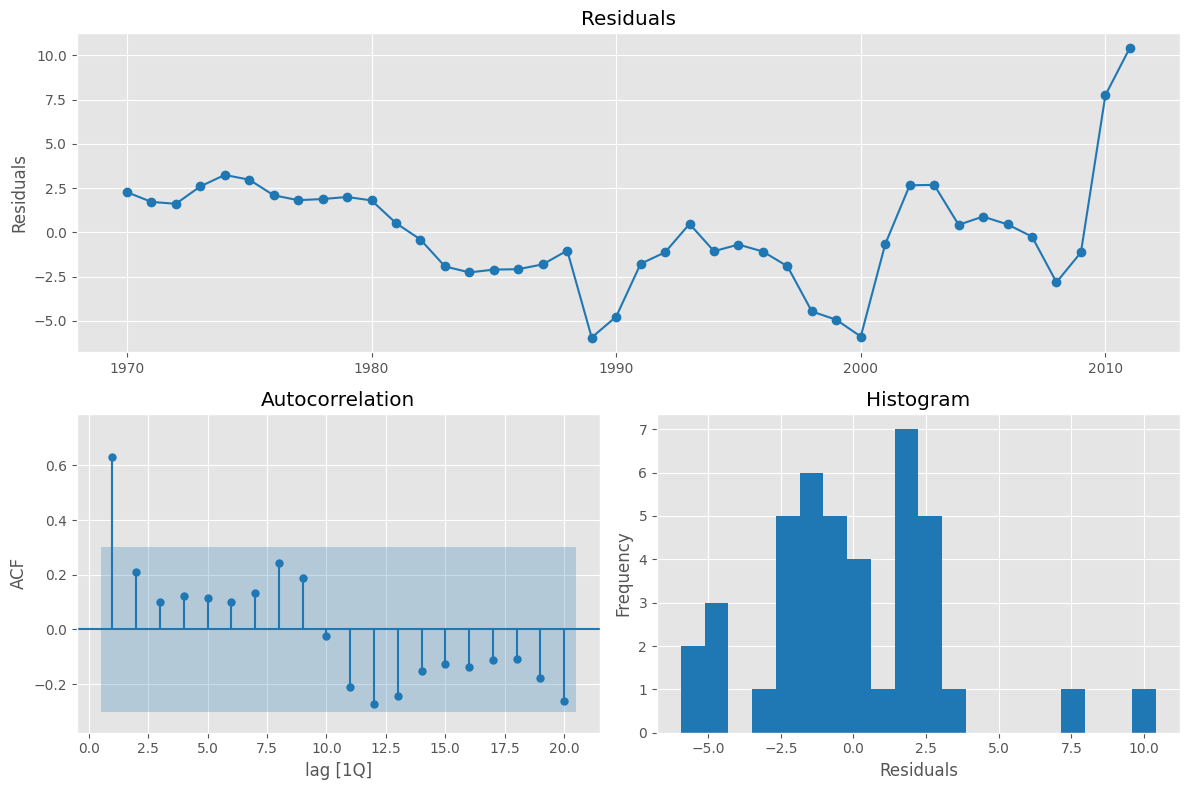

In [ ]:
plot_diagnostics_from_model(
    forecaster=mf, target_col="Passengers", time_col="Year", n_lags=20
)

# [Some useful predictors](https://otexts.com/fpppy/nbs/07-regression.html#sec-useful-predictors)

In [34]:
# Read data
aus_production = pd.read_csv("data/aus_production_formatted.csv", parse_dates=[1])
recent_production = (
    aus_production[
        (aus_production["unique_id"] == "Beer") & (aus_production["ds"] >= "1992-01-01")
    ]
    .reset_index(drop=True)
    .copy()
)

recent_production.head()

,unique_id,ds,y
0,Beer,1992-03-01,443.0
1,Beer,1992-06-01,410.0
2,Beer,1992-09-01,420.0
3,Beer,1992-12-01,532.0
4,Beer,1993-03-01,433.0


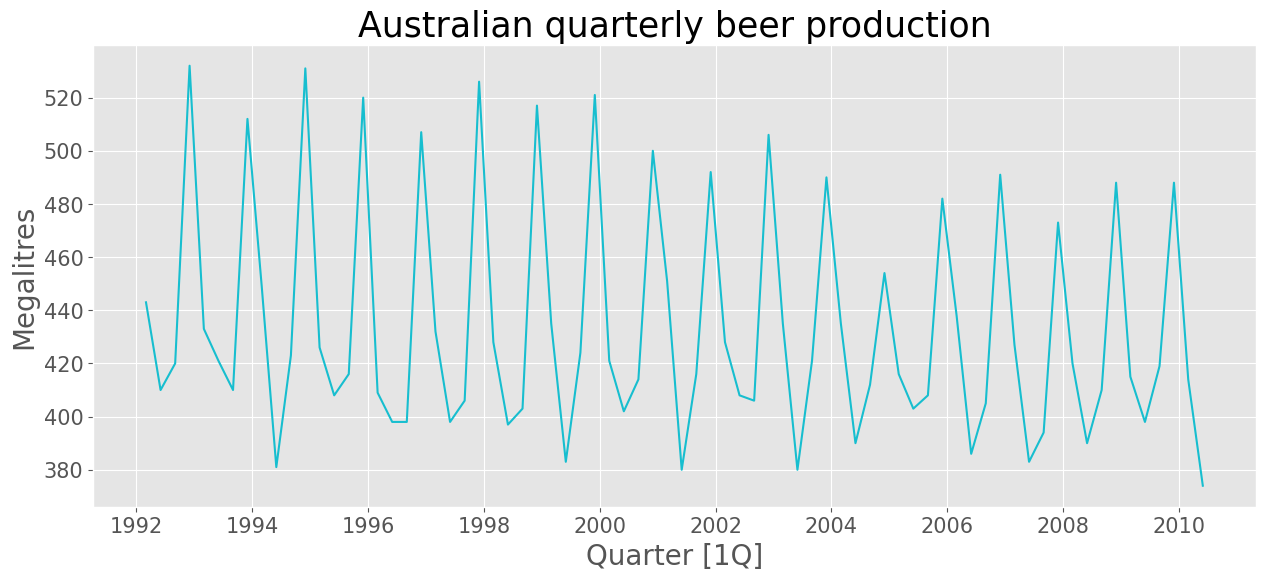

In [35]:
plot_series(
    recent_production,
    xlabel="Quarter [1Q]",
    ylabel="Megalitres",
    title="Australian quarterly beer production",
)

In [ ]:
fit_beer = recent_production.copy()
# Add trend
fit_beer, _ = trend(fit_beer, freq="QS-DEC")
# Add quarterly indicators
quarter = pd.get_dummies(fit_beer.ds.dt.quarter, prefix="Quarter", drop_first=True)
fit_beer = fit_beer.join(quarter)
fit_beer.head()

,unique_id,ds,y,trend,Quarter_2,Quarter_3,Quarter_4
0,Beer,1992-03-01,443.0,1.0,False,False,False
1,Beer,1992-06-01,410.0,2.0,True,False,False
2,Beer,1992-09-01,420.0,3.0,False,True,False
3,Beer,1992-12-01,532.0,4.0,False,False,True
4,Beer,1993-03-01,433.0,5.0,False,False,False


In [49]:
mf = MLForecast(
    models=LinearRegression(),
    freq="QS-DEC",
)

mf.fit(fit_beer, fitted=True, static_features=[])

insample_forecasts = mf.forecast_fitted_values()["LinearRegression"]
residuals = mf.models_["LinearRegression"]._residuals

print_regression_summary_from_model(mf.models_["LinearRegression"])

#> Residuals:
#>     Min      1Q  Median      3Q     Max 
#> -42.9030 -7.5995 -0.4594  7.9908 21.7895

#> Coefficients:
#>                Estimate  Std. Error   t value  Pr(>|t|)
#>   (Intercept)  441.8002      3.7335    118.33         0 ***
#>         trend   -0.3403      0.0666     -5.11  2.73e-06 ***
#>     Quarter_2  -34.6597      3.9683     -8.73   9.1e-13 ***
#>     Quarter_3  -17.8216      4.0225     -4.43  3.45e-05 ***
#>     Quarter_4   72.7964      4.0230     18.09         0 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.229 on 69 degrees of freedom
Multiple R-squared: 0.924,   Adjusted R-squared: 0.920
F-statistic: 210.7 on 69 DF, p-value: 1.11e-16


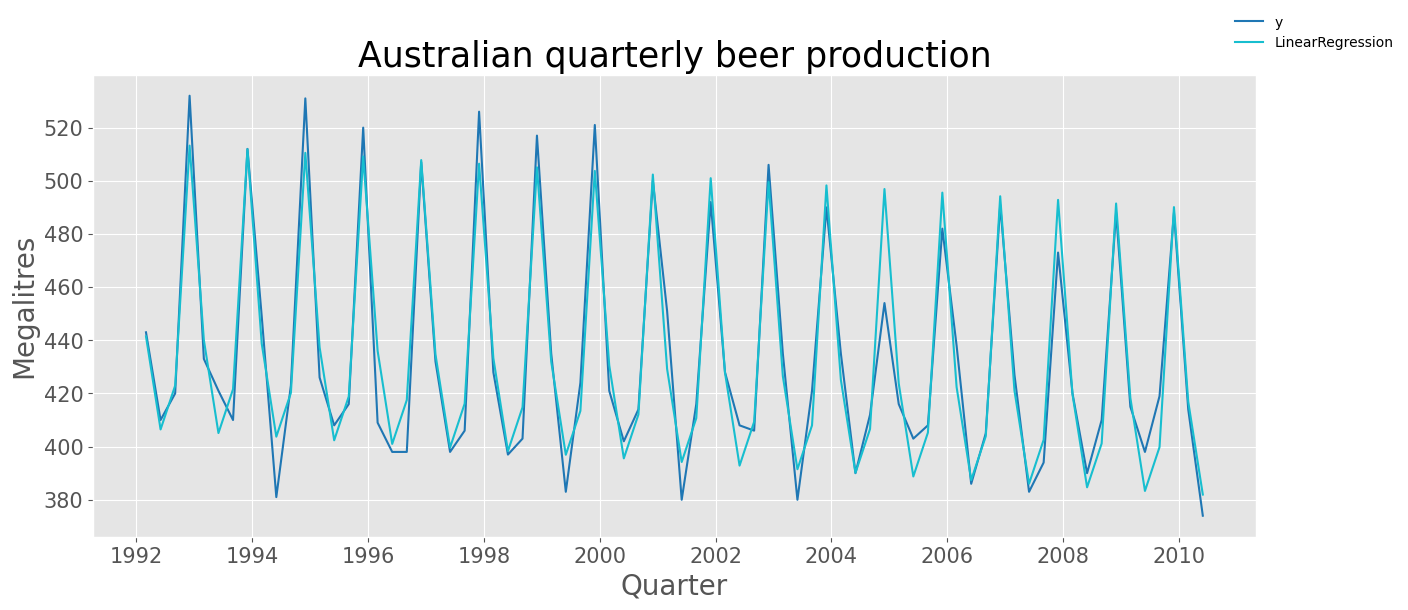

In [50]:
plot_series(
    df=fit_beer,
    forecasts_df=mf.forecast_fitted_values().drop(columns="y"),
    xlabel="Quarter",
    ylabel="Megalitres",
    title="Australian quarterly beer production",
    rm_legend=False,
)

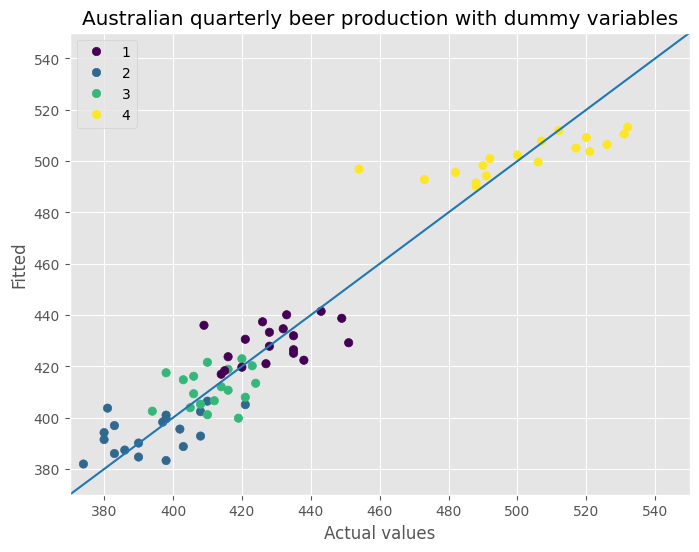

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    mf.forecast_fitted_values()["y"],
    insample_forecasts,
    label="Fitted",
    c=fit_beer["ds"].dt.quarter,
)
ax.axline((0, 0), slope=1)
ax.set_xlim(370, 550)
ax.set_ylim(370, 550)
ax.set_xlabel("Actual values")
ax.set_ylabel("Fitted")
ax.set_title("Australian quarterly beer production with dummy variables")
ax.legend(*sc.legend_elements())
plt.show()

In [52]:
fourier_beer = recent_production.copy()
# Add trend
fourier_beer, _ = trend(fourier_beer, freq="QS-DEC")
# Add fourier
fourier_beer, _ = fourier(fourier_beer, freq="QS-DEC", k=2, season_length=4)
fourier_beer.head(10)

,unique_id,ds,y,trend,sin1_4,sin2_4,cos1_4,cos2_4
0,Beer,1992-03-01,443.0,1.0,1.000e+00,-8.742e-08,-4.371e-08,-1.0
1,Beer,1992-06-01,410.0,2.0,-8.742e-08,1.748e-07,-1.000e+00,1.0
2,Beer,1992-09-01,420.0,3.0,-1.000e+00,-2.385e-08,1.192e-08,-1.0
3,Beer,1992-12-01,532.0,4.0,1.748e-07,3.497e-07,1.000e+00,1.0
4,Beer,1993-03-01,433.0,5.0,1.000e+00,-6.755e-07,-3.378e-07,-1.0
5,Beer,1993-06-01,421.0,6.0,-2.385e-08,4.770e-08,-1.000e+00,1.0
6,Beer,1993-09-01,410.0,7.0,-1.000e+00,-1.327e-06,6.636e-07,-1.0
7,Beer,1993-12-01,512.0,8.0,3.497e-07,6.994e-07,1.000e+00,1.0
8,Beer,1994-03-01,449.0,9.0,1.000e+00,-7.155e-08,-3.577e-08,-1.0
9,Beer,1994-06-01,381.0,10.0,-6.755e-07,1.351e-06,-1.000e+00,1.0


In [53]:
mf = MLForecast(
    models=LinearRegression(),
    freq="QS-DEC",
)

mf.fit(fourier_beer, fitted=True, static_features=[])

insample_forecasts = mf.forecast_fitted_values()["LinearRegression"]
residuals = mf.models_["LinearRegression"]._residuals

print_regression_summary_from_model(mf.models_["LinearRegression"])

#> Residuals:
#>     Min      1Q  Median      3Q     Max 
#> -42.9030 -7.5996 -0.4594  7.9908 21.7894

#> Coefficients:
#>                Estimate  Std. Error   t value  Pr(>|t|)
#>   (Intercept)  446.8792      2.8955    154.33         0 ***
#>         trend   -0.3403      0.0671     -5.07  3.25e-06 ***
#>        sin1_4    8.9109      2.0371      4.37  4.29e-05 ***
#>        sin2_4    0.0001 389943.4398      0.00         1 
#>        cos1_4   53.7281      2.0264     26.51         0 ***
#>        cos2_4   13.9896      1.9503      7.17  6.91e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.319 on 68 degrees of freedom
Multiple R-squared: 0.924,   Adjusted R-squared: 0.919
F-statistic: 166.1 on 68 DF, p-value: 1.11e-16


# [Selecting predictors](https://otexts.com/fpppy/nbs/07-regression.html#sec-selecting-predictors)

In [ ]:
# US Change example
us_change = pd.read_csv("data/US_change.csv", parse_dates=[0])
mf = MLForecast(
    models=LinearRegression(),
    freq="QS-OCT",
)

mf.fit(us_change, fitted=True, static_features=[])
insample_forecasts = mf.forecast_fitted_values()["LinearRegression"]
insample_y = mf.forecast_fitted_values()["y"]
T = len(insample_y)
k = len(mf.models_["LinearRegression"].coef_)

print(f"Adjusted R^2 score: {adj_r2_score(insample_y, insample_forecasts, T, k):.3f}")
print(
    f"CV score          : {cv_score(mf, us_change, model='LinearRegression', target_col='y', n_windows=10, h=1):.3f}"
)
print(f"AIC score         : {aic_score(insample_y, insample_forecasts, T, k):.3f}")
print(f"AICc score        : {aicc_score(insample_y, insample_forecasts, T, k):.3f}")
print(f"BIC score         : {bic_score(insample_y, insample_forecasts, T, k):.3f}")

Adjusted R^2 score: 0.763
CV score          : 0.249
AIC score         : -456.580
AICc score        : -456.140
BIC score         : -436.850


# [Forecasting with regression](https://otexts.com/fpppy/nbs/07-regression.html#sec-forecasting-regression)